# Rppg 신호측정

In [71]:
import cv2
from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [72]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(average_pr, band[0]), band[1])

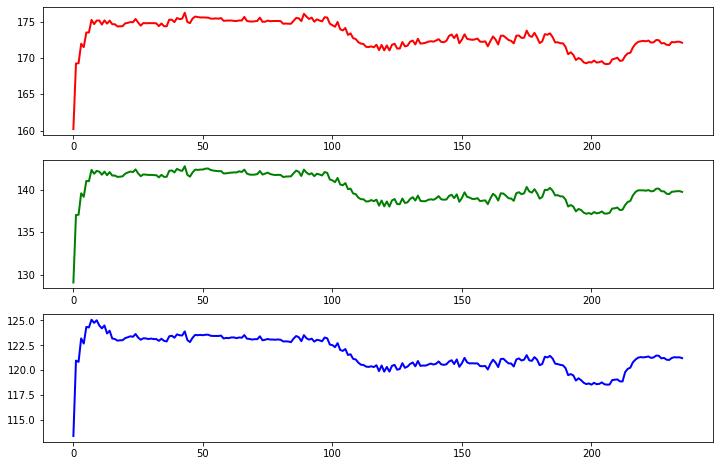

In [76]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')
cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
time.sleep(2)

try:
    while True:
        # 프레임 가져오기
        ok, frame = cap.read()

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0]
            prev_bbox = curr_bbox
        else:
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
finally:
    cv2.destroyAllWindows()
    cap.release()
    
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)

plt.show()

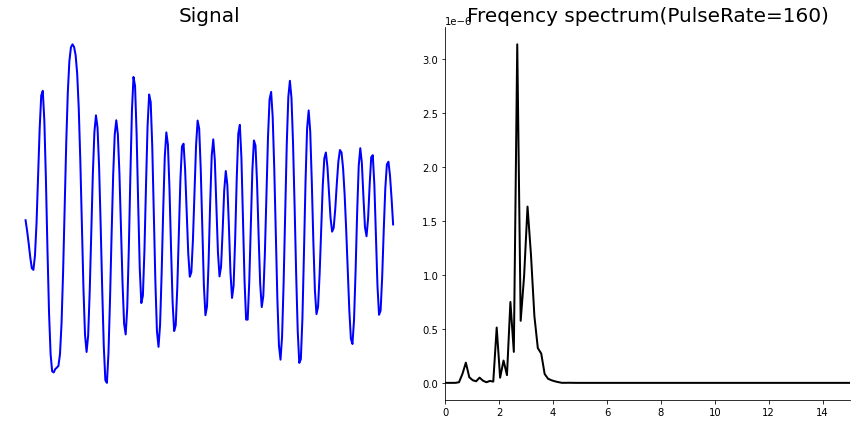

In [77]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

In [11]:
print(pulse.shape)


(253,)


- 데이터 csv로 저장하기

In [ ]:
f = open('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\cppg_ysg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(cppg_frequency_features.keys()) 
wr.writerow(cppg_frequency_features.values()) 
f.close()

In [78]:
f = open('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\rppg_ysg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(pulse) 
f.close()

# csv데이터불러오기

In [1]:
import os
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import math

In [2]:
import csv
 
f = open('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\cppg0.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    cppg_data=line
    print(line)
print(type(cppg_data))
f.close()   

['1491', '1474', '1458', '1443', '1429', '1416', '1405', '1393', '1383', '1373', '1366', '1354', '1340', '1327', '1313', '1297', '1282', '1265', '1251', '1235', '1217', '1202', '1186', '1172', '1159', '1150', '1141', '1133', '1122', '1111', '1098', '1084', '1072', '1061', '1048', '1037', '1027', '1014', '1001', '991', '984', '978', '975', '973', '973', '974', '976', '982', '989', '998', '1009', '1021', '1037', '1060', '1086', '1118', '1154', '1192', '1234', '1279', '1332', '1387', '1451', '1518', '1591', '1665', '1745', '1828', '1915', '2008', '2098', '2189', '2274', '2357', '2434', '2502', '2563', '2614', '2658', '2709', '2736', '2752', '2766', '2774', '2779', '2782', '2779', '2771', '2757', '2738', '2716', '2691', '2663', '2631', '2596', '2561', '2528', '2493', '2461', '2430', '2401', '2369', '2340', '2312', '2280', '2248', '2216', '2179', '2143', '2102', '2061', '2017', '1961', '1917', '1874', '1831', '1796', '1763', '1734', '1712', '1691', '1678', '1671', '1667', '1667', '1670', '1

In [3]:
import csv
 
f = open('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\rppg0.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    rppg_data=line
    print(line)
print(type(rppg_data))
f.close()   

['-9.562829097791214e-06', '-0.002813485780921998', '-0.005162093758135232', '-0.0067427779096591155', '-0.0074664251542436565', '-0.007451073407460556', '-0.0069260296400398885', '-0.006115092111078375', '-0.0051626456026222355', '-0.004130685719332713', '-0.003045815123299483', '-0.0019488024437851656', '-0.000909965630580177', '-6.76375649825197e-06', '0.000711788560425529', '0.0012439584833004035', '0.0016241940676520099', '0.001892763863820215', '0.002070265182165575', '0.002155123149946276', '0.002142353767798378', '0.002044679584135632', '0.0018967795446006642', '0.0017396037748082585', '0.0015994975842636033', '0.0014804783396239678', '0.001374765794489858', '0.0012794506659556124', '0.0012022298988467453', '0.0011507369676349508', '0.001116657858287119', '0.001071496501543067', '0.0009802791971863295', '0.000822891913798975', '0.0006055870725983103', '0.00035340902417865263', '8.967986159633622e-05', '-0.00018189822346823805', '-0.0004796231545586768', '-0.000828585199553191',

# 데이터 정규화 0~1

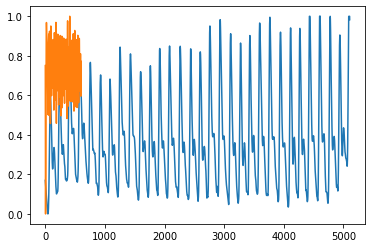

In [4]:
from sklearn.preprocessing import MinMaxScaler

def normalization(ppg_data):

    # MinMaxScaler객체 생성
    scaler = MinMaxScaler()
    # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
    scaler.fit(ppg_data.reshape(len(ppg_data),1))
    ppg_scaled = scaler.transform(ppg_data.reshape(len(ppg_data),1))
    plt.plot(ppg_scaled)
    
    return ppg_scaled.reshape(len(ppg_data))

# list를 numpy array로
cppg_data=np.array(cppg_data)
rppg_data=np.array(rppg_data)
cppg_scaled=normalization(cppg_data)
rppg_scaled=normalization(rppg_data)

# peak detection

In [10]:
# peak 찾는 함수(amplitude)
def detect_peak(hrdata):
    point=scipy.signal.find_peaks(hrdata,distance=100)
#     print(point[0])
# point[0]가 peak의 x좌표 hrdata[point[0]]이 peak의 y좌표
    plt.scatter(point[0],hrdata[point[0]])
    plt.plot(hrdata)
#     plt.axis([0, 1000,0,1])
    peak=np.zeros(len(point[0]))
    for i in range(len(point[0])):
        peak[i]=(hrdata[point[0][i]])
#     print(peak)
# peak = peak 값 (y축값), point[0] = peak의 x위치
    return(peak,point[0])
# detect_peak(hrdata)

(5105,)
(601,)


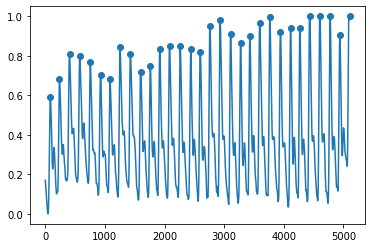

In [11]:
# cppg_data=np.array(cppg_data)
# rppg_data=np.array(rppg_data)
print(cppg_scaled.shape)
print(rppg_scaled.shape)
cppg_peaks,cppg_points= detect_peak(cppg_scaled) # peak의 y값과 x값 반환 , 100

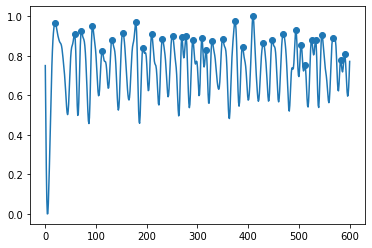

In [7]:
rppg_peaks,rppg_points= detect_peak(rppg_scaled)  # peak의 y값과 x값 반환 , 12 8

In [12]:
print(len(cppg_peaks))
print(len(rppg_peaks))
print(len(cppg_points))
print(len(rppg_points))  # peak개수 동일해지게끔 자동화함수만들기

31
34
31
34


# RR-interval 구하기

In [91]:
# print(cppg_points.shape)
# print(rppg_points.shape)
def length(x1,y1,x2,y2):
    return math.sqrt(math.pow(x2-x1,2)+math.pow(y2-y1,2))

def cal_hrv(peak_y,peak_x):
    hrv=np.zeros(len(peak_x)-1)
    print("hrv_shape:", hrv.shape)
    for i in range (len(peak_x)-1):
        peak_dist= length(peak_x[i],peak_y[i],peak_x[i+1],peak_y[i+1])
#         print(peak_dist)
        hrv[i]=peak_dist
    print(hrv)
    return hrv

#cppg_hrv=cal_hrv(cppg_peaks,cppg_points)
rppg_hrv=cal_hrv(rppg_peaks,rppg_points)


#print(cppg_points.shape)#peak의 x좌표
#print(cppg_peaks.shape)#peak의 y좌표
#length(cppg_points[0],cppg_peaks[0],cppg_points[1],cppg_peaks[1])

hrv_shape: (20,)
[19.0004962  15.00146531 13.00000824 11.00074319 10.00013381 11.00056943
 11.00005066  9.00025919 10.00015429  8.00054695  9.00103348  9.00011755
 11.00093306 12.00004491 12.00031904 11.00070138  9.00000297 13.00000111
  8.00002664 10.00001875]


# hrv feature

In [92]:
from hrvanalysis import get_frequency_domain_features
#cppg_frequency_features = get_frequency_domain_features(cppg_hrv)
rppg_frequency_features = get_frequency_domain_features(rppg_hrv)

#print("cppg:",cppg_frequency_features)
print("rppg:",rppg_frequency_features)


rppg: {'lf': 0.3768701725167623, 'hf': 0.8733816696420205, 'lf_hf_ratio': 0.43150684931506855, 'lfnu': 30.14354066985646, 'hfnu': 69.85645933014354, 'total_power': 1.3758752329977035, 'vlf': 0.12562339083892074}


C:\Users\ysk00\Anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 2, using nperseg = 2
  .format(nperseg, input_length))


In [25]:
from hrvanalysis import get_time_domain_features
cppg_time_features = get_time_domain_features(cppg_hrv)
rppg_time_features = get_time_domain_features(rppg_hrv)

print(cppg_time_features)
print(rppg_time_features)

{'mean_nni': -1.6451612903225807, 'sdnn': 310.06714846810166, 'sdsd': 496.28430919741515, 'nni_50': 26, 'pnni_50': 83.87096774193549, 'nni_20': 30, 'pnni_20': 96.7741935483871, 'rmssd': 498.09791540753645, 'median_nni': -4.0, 'range_nni': 1282.0, 'cvsd': -302.7653995614437, 'cvnni': -188.47218828453236, 'mean_hr': inf, 'max_hr': inf, 'min_hr': -15000.0, 'std_hr': nan}
{'mean_nni': 0.00022113732099999999, 'sdnn': 0.0022912252957931816, 'sdsd': 0.00373137160954352, 'nni_50': 0, 'pnni_50': 0.0, 'nni_20': 0, 'pnni_20': 0.0, 'rmssd': 0.003737334586339353, 'median_nni': -0.00046133862500000004, 'range_nni': 0.01066548409, 'cvsd': 16.90051489019962, 'cvnni': 10.361097283046048, 'mean_hr': -40016299.26323609, 'max_hr': 66030508.93443961, 'min_hr': -375531729.45818037, 'std_hr': 92022004.73403198}


# csv로 기록

In [69]:
cppg_frequency_features['name']="soeui"
print(cppg_frequency_features.values())
f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\cppg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(cppg_frequency_features.keys()) 
wr.writerow(cppg_frequency_features.values()) 
f.close()

dict_values([0.10822306266329913, 0.50597153800256, 0.21389160167098484, 17.62032140073726, 82.37967859926273, 0.6211251835636167, 0.006930582897757498, 'soeui'])


In [ ]:
rppg_frequency_features['name']="soeui"
print(cppg_frequency_features.values())
f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\rppg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(rppg_frequency_features.keys()) 
wr.writerow(rppg_frequency_features.values()) 
f.close()